In [17]:
import os, glob
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

In [2]:
def compute_accuracy(preds_df, labels_column, pred_column):
    return preds_df.groupby('language')[[labels_column, pred_column]]\
        .apply(lambda x: (x[labels_column] == x[pred_column])\
               .mean())\
                .reset_index()\
                    .rename(columns={0: 'accuracy'})

In [4]:
def plot(df):
    topics = df.index
    languages = df.columns
    x = np.arange(len(topics))  # label locations
    width = 0.2  # bar width

    fig, ax = plt.subplots(figsize=(12, 6))
    colors = {'de': 'indianred', 'fr': 'royalblue', 'it': 'seagreen'}

    # Plot bars for each language
    for i, lang in enumerate(languages):
        ax.bar(x + i * width, df[lang], width, color=colors[lang], label=lang)

    ax.set_xlabel("Topic")
    ax.set_ylabel("Accuracy")
    ax.set_title("Accuracy by Topic and Language")
    ax.set_xticks(x + width, topics, rotation=45, ha="right")
    ax.legend(loc='upper center', ncol=len(languages))
    ax.grid(axis="y", linestyle="--", alpha=0.7)

    plt.tight_layout()
    plt.show()

In [5]:
def plot_metrics(model_dir):
    last_ckpt = os.path.join(glob.glob(os.path.join(model_dir, 'checkpoint-*'))[-1], 'trainer_state.json')

    with open(last_ckpt, 'r') as file:
        data = json.load(file)

    log_history = (pd.DataFrame(data['log_history'])
                .groupby("epoch")
                .agg(lambda x: x.dropna().iloc[0] if not x.dropna().empty else None)
                .reset_index())
    
    log_history.plot(x='epoch', 
                     y=['eval_accuracy', 'eval_loss', 'loss'], 
                     label=['Validation Accuracy', 'Validation Loss', 'Training Loss'], 
                     color=['green', 'red', 'maroon'], 
                     grid=True
                     )

In [70]:
def analyze_errors(df):
    incorrect_preds = df.query("label != prediction")

    # Compute FP and FN by language
    result = incorrect_preds.groupby('language')['prediction'].agg(
        FP=lambda x: round((x == 'FAVOR').sum() / len(x) * 100, 2),  # (AGAINST → FAVOR)
        FN=lambda x: round((x == 'AGAINST').sum() / len(x) * 100, 2),  # (FAVOR → AGAINST)
        ).reset_index().rename(columns={'FP': 'FP (%)', 'FN': 'FN (%)'})

    return result

---

In [3]:
# train = pd.read_json('../../data/xstance/train.jsonl', lines=True)
# train['topic'].value_counts()

---
## Binary

### Baseline

In [19]:
bi_baseline_preds = pd.read_csv('../../predictions/bi_baseline_preds.csv')
bi_baseline_acc = compute_accuracy(bi_baseline_preds, 'label', 'prediction')

### Fine-tuned

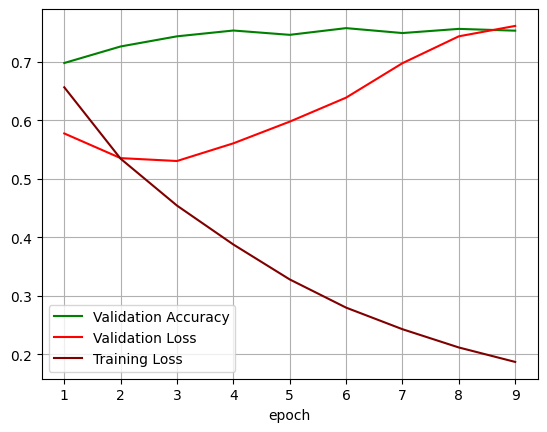

In [8]:
model_dir = "../../models/binary_stance_classifier/"
plot_metrics(model_dir)

In [21]:
# Only comments
test_preds = pd.read_csv('../../predictions/xstance_test_preds_finetuned.csv')
compute_accuracy(test_preds, 'label', 'prediction')

,language,accuracy
0,de,0.711547
1,fr,0.728938
2,it,0.720609


In [7]:
# Questions + comments
bi_test_preds = pd.read_csv('../../predictions/bi_test_preds.csv')
bi_ft_acc = compute_accuracy(bi_test_preds, 'label', 'prediction')
bi_ft_acc

,language,accuracy
0,de,0.726095
1,fr,0.755037
2,it,0.737206


**Question:** How many times has the stance changed and in which direction?

In [71]:
analyze_errors(bi_test_preds)

,language,FP (%),FN (%)
0,de,45.41,54.59
1,fr,38.97,61.03
2,it,44.74,55.26


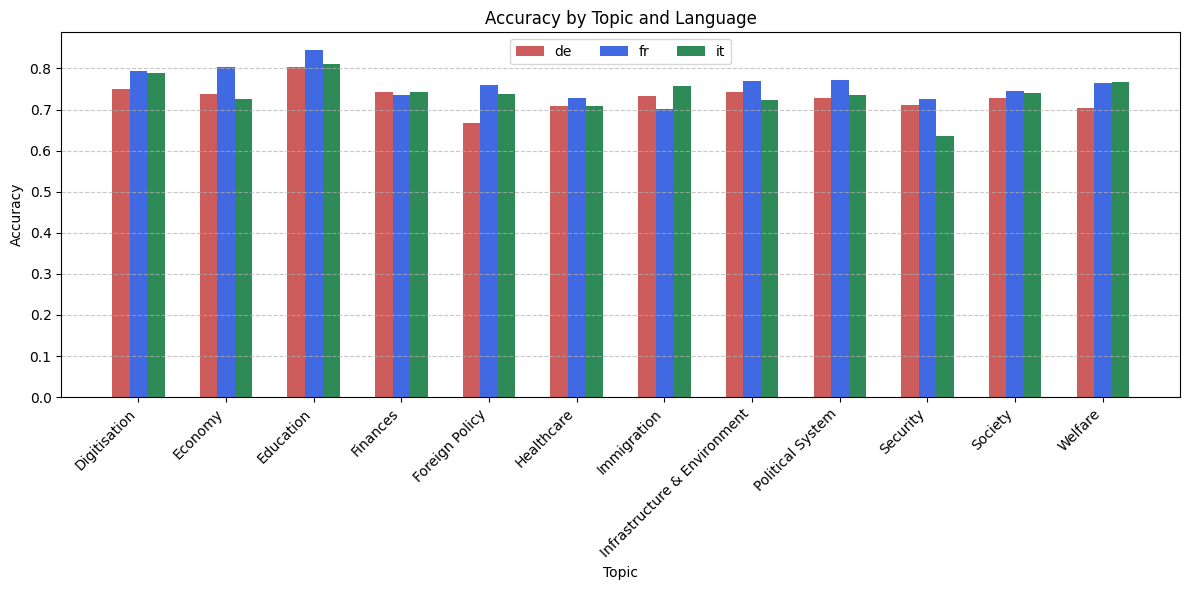

In [12]:
bi_test_preds_by_topics = bi_test_preds.groupby(['topic', 'language'])[['label', 'prediction']]\
    .apply(lambda x: (x['label'] == x['prediction']).mean())\
    .reset_index()\
    .pivot(index='topic', columns='language', values=0)

plot(bi_test_preds_by_topics)

### Translated

In [28]:
de2fr_preds = pd.read_csv('../../predictions/de2fr_preds.csv')
de2fr_acc = compute_accuracy(de2fr_preds, 'label', 'prediction').assign(trans_description='German → French')

fr2de_preds = pd.read_csv('../../predictions/fr2de_preds.csv')
fr2de_acc = compute_accuracy(fr2de_preds, 'label', 'prediction').assign(trans_description='French → German')

it2fr_preds = pd.read_csv('../../predictions/it2fr_preds.csv')
it2fr_acc = compute_accuracy(it2fr_preds, 'label', 'prediction').assign(trans_description='Italian → French')

it2de_preds = pd.read_csv('../../predictions/it2de_preds.csv')
it2de_acc = compute_accuracy(it2de_preds, 'label', 'prediction').assign(trans_description='Italian → German')

translated_acc = pd.concat([de2fr_acc, fr2de_acc, it2fr_acc, it2de_acc]).reset_index(drop=True)
translated_acc

,language,accuracy,trans_description
0,de,0.671516,German → French
1,fr,0.691392,French → German
2,it,0.716459,Italian → French
3,it,0.699170,Italian → German


In [72]:
de2fr_err = analyze_errors(de2fr_preds).assign(trans_description='German → French')
fr2de_err = analyze_errors(fr2de_preds).assign(trans_description='French → German')
it2fr_err = analyze_errors(it2fr_preds).assign(trans_description='Italian → French')
it2de_err = analyze_errors(it2de_preds).assign(trans_description='Italian → German')

trans_err = pd.concat([de2fr_err, fr2de_err, it2fr_err, it2de_err]).reset_index(drop=True)
trans_err

,language,FP (%),FN (%),trans_description
0,de,42.83,57.17,German → French
1,fr,47.11,52.89,French → German
2,it,40.00,60.00,Italian → French
3,it,45.06,54.94,Italian → German


---
## Multi-class

### Baseline

In [57]:
multi_base_preds = pd.read_csv('../../predictions/multi_baseline_preds.csv')
multi_base_acc = compute_accuracy(multi_base_preds, 'numerical_label', 'prediction')

### Fine-tuned

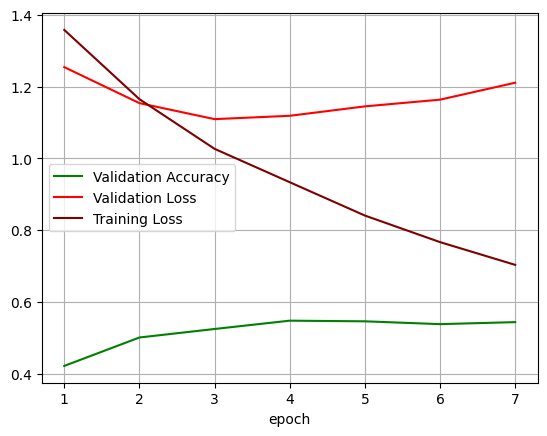

In [14]:
model_dir = "../../models/multi_micro_stance_classifier/"
plot_metrics(model_dir)

In [58]:
multi_micro_preds = pd.read_csv('../../predictions/multi_micro_preds.csv')
multi_micro_acc = compute_accuracy(multi_micro_preds, 'numerical_label', 'prediction')

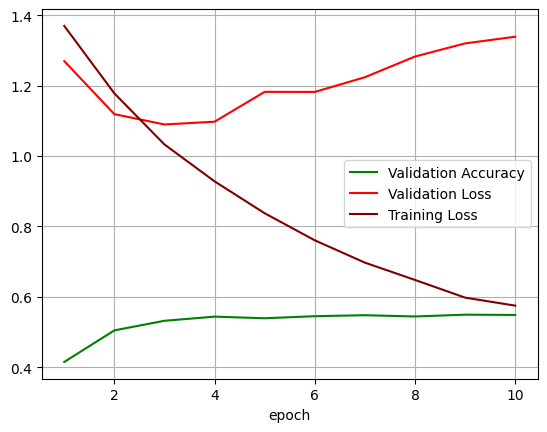

In [53]:
model_dir = "../../models/multi_macro_stance_classifier/"
plot_metrics(model_dir)

In [59]:
multi_macro_preds = pd.read_csv('../../predictions/multi_macro_preds.csv')
multi_macro_acc = compute_accuracy(multi_macro_preds, 'numerical_label', 'prediction')

---
## All accuracies

In [21]:
bi_acc = reduce(lambda left, right: pd.merge(left, right, on='language'), [
    bi_baseline_acc.rename(columns={'accuracy': 'acc_baseline'}),
    bi_ft_acc.rename(columns={'accuracy': 'acc_finetuned'}),
    translated_acc.rename(columns={'accuracy': 'acc_translated'}),
])

bi_acc

,language,acc_baseline,acc_finetuned,acc_translated,trans_description
0,de,0.494660,0.726095,0.671516,German → French
1,fr,0.456502,0.755037,0.691392,French → German
2,it,0.460581,0.737206,0.716459,Italian → French
3,it,0.460581,0.737206,0.699170,Italian → German


In [68]:
multi_acc = reduce(lambda left, right: pd.merge(left, right, on='language'), [
    multi_base_acc.rename(columns={'accuracy': 'baseline'}),
    multi_micro_acc.rename(columns={'accuracy': 'finetuned_MicroAvg'}),
    multi_macro_acc.rename(columns={'accuracy': 'finetuned_MacroAvg'})
])
multi_acc

,language,baseline,finetuned_MicroAvg,finetuned_MacroAvg
0,de,0.282062,0.503574,0.494660
1,fr,0.304945,0.543040,0.523352
2,it,0.269018,0.508299,0.499308
